[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 13.321776
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 7513, number of used features: 21
[LightGBM] [Info] Start training from score 12.609529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

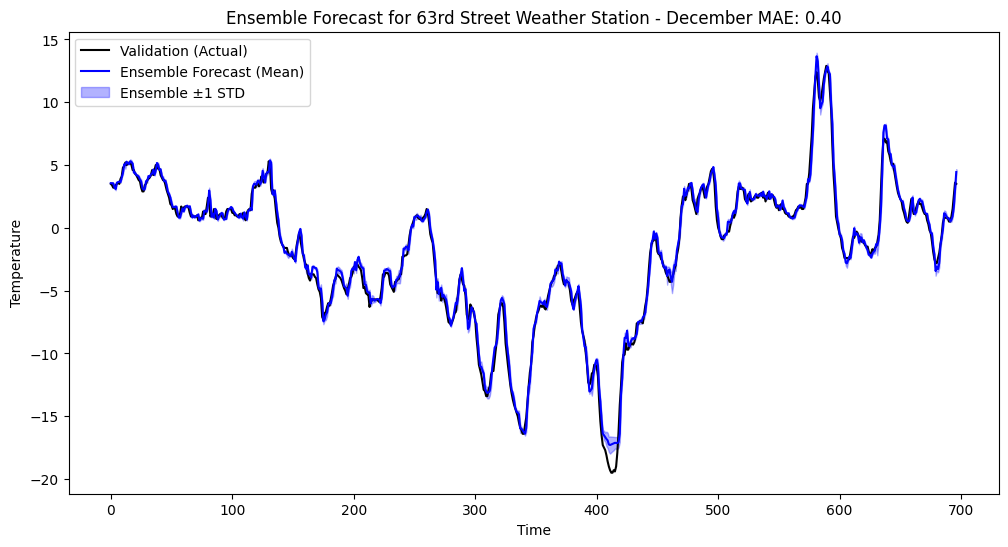

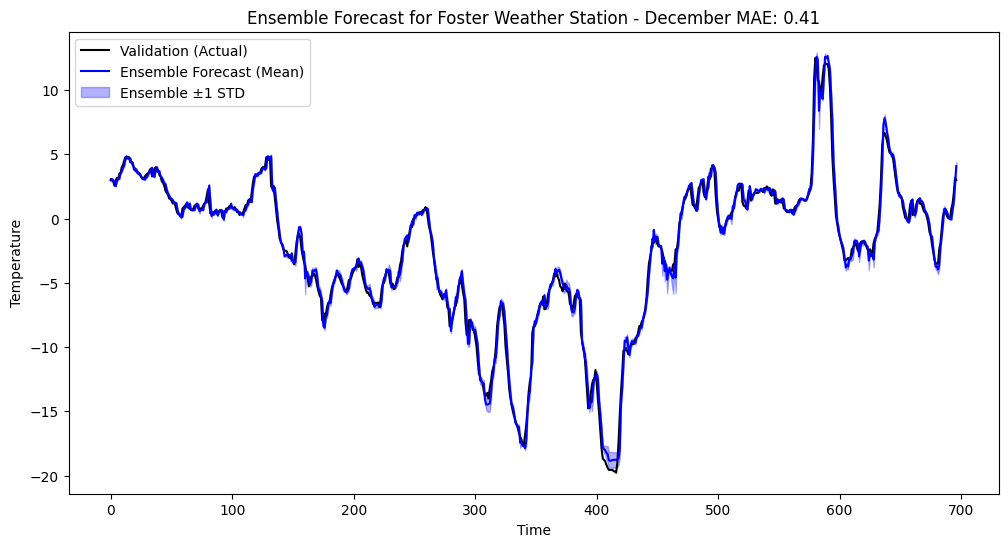

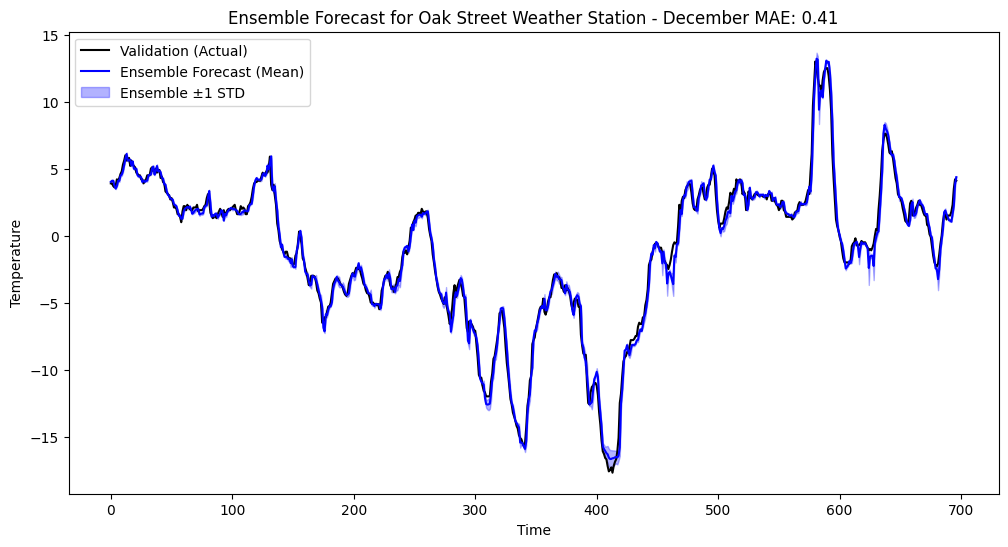

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = './data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

station_names = df_pivot.columns
lagged_data = pd.DataFrame()
for station in station_names:
    for lag in range(1, 8):
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()

train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
ensemble_forecast_results = {}

for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    lgb_model = lgb.LGBMRegressor(n_estimators=100)
    rf_model = RandomForestRegressor(n_estimators=100)
    
    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    
    xgb_pred = xgb_model.predict(X_val)
    lgb_pred = lgb_model.predict(X_val)
    rf_pred = rf_model.predict(X_val)
    
    ensemble_preds = np.array([xgb_pred, lgb_pred, rf_pred])
    ensemble_mean = ensemble_preds.mean(axis=0)
    ensemble_std = ensemble_preds.std(axis=0)
    
    mae_scores[station] = mean_absolute_error(y_val, ensemble_mean)
    
    ensemble_forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'ensemble_mean': ensemble_mean,
        'ensemble_std': ensemble_std
    }

for station, results in ensemble_forecast_results.items():
    plt.figure(figsize=(12, 6))
    
    plt.plot(results['validation'].values, label="Validation (Actual)", color="black")
    
    plt.plot(results['ensemble_mean'], label="Ensemble Forecast (Mean)", color="blue")
    
    plt.fill_between(range(len(results['ensemble_mean'])), 
                     results['ensemble_mean'] - results['ensemble_std'], 
                     results['ensemble_mean'] + results['ensemble_std'], 
                     color="blue", alpha=0.3, label="Ensemble ±1 STD")
    
    plt.legend()
    plt.title(f"Ensemble Forecast for {station} - December MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

print("Ensemble MAE for Each Station:")
for station, mae in mae_scores.items():
    print(f"Station: {station}, MAE: {mae:.2f}")